In [ ]:
'''Суть задачи: проанализировать итоги A/B теста и решить нужно ли выкатывать новую модель на остальных пользователей'''

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from datetime import datetime
import numpy as np
import plotly.express as px
from tqdm.auto import tqdm
import scipy.stats as st
import statsmodels.stats.multicomp as sm
from scipy.stats import norm, mannwhitneyu
path1 = ('https://stepik.org/media/attachments/lesson/426730/active_users.csv')
path2 = ('https://stepik.org/media/attachments/lesson/426730/groups.csv')
path3 = ('https://stepik.org/media/attachments/lesson/426730/purchases.csv')
active_users = pd.read_csv(path1, sep=',')
groups = pd.read_csv(path2, sep=',')
purchases = pd.read_csv(path3, sep=',')


In [4]:
df = groups.merge(active_users, how = 'left', on = 'user_id')

In [5]:
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [21]:
#a - контрольная группа, b - тестовая группа

ds = df.merge(purchases, how = 'left', on = 'user_id')
new_df = ds[['user_id', 'group', 'revenue']]
new_df = new_df.dropna()
new_df
ds.to_csv('ds.csv', sep = ',')
ds

,user_id,group,country,platform,sex,revenue
0,9149,B,NaN,NaN,NaN,NaN
1,9150,B,NaN,NaN,NaN,NaN
2,9151,A,NaN,NaN,NaN,NaN
3,9152,B,NaN,NaN,NaN,NaN
4,9153,B,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
74571,1010,B,Sweden,android,male,NaN
74572,7785,A,Sweden,android,male,NaN
74573,1783,B,Russia,ios,female,NaN
74574,1164,A,Sweden,android,male,NaN


In [7]:
new_df.sort_values(['revenue'])

,user_id,group,revenue
74049,876,B,207.0
29294,9146,B,207.0
65653,1056,B,208.0
65598,6988,B,208.0
73818,5122,B,208.0
...,...,...,...
64411,1227,B,3670.0
72833,591,A,3670.0
74282,1606,A,3671.0
72906,6483,B,3671.0


In [8]:
new_df.groupby (['group'], as_index = False) \
                    .agg({'revenue' : 'sum'})


,group,revenue
0,A,93162.0
1,B,485575.0


In [9]:
gorup_a = new_df.query("group == 'A'")
gorup_b = new_df.query("group == 'B'")
gorup_b


,user_id,group,revenue
60,9061,B,699.0
593,9036,B,300.0
594,9073,B,702.0
1722,9130,B,591.0
3910,9035,B,700.0
...,...,...,...
74542,239,B,298.0
74550,1259,B,1398.0
74564,6065,B,852.0
74566,4850,B,1000.0


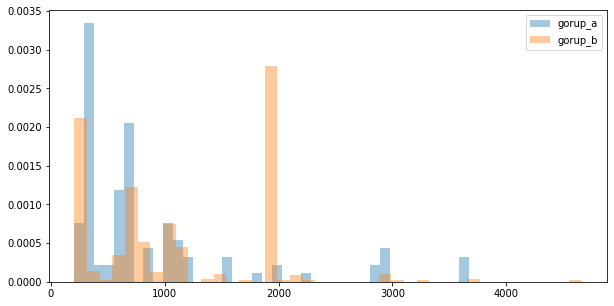

In [10]:
plt.figure(figsize=(10,5))
plt.hist(gorup_a['revenue'], bins = 40, density = True, alpha = 0.4, label='gorup_a')
plt.hist(gorup_b['revenue'], bins = 40, density = True, alpha = 0.4, label='gorup_b')
plt.legend()

In [11]:
# Для визуализации распределения доходов в тестовой и контрольной группе была построена гистограмма.
# На гистограмме видно, что в тестовой группе больше дорогих заказов по сравнению с контрольной, в контрольной - 
# больше недорогих

In [12]:
rev_a = gorup_a.groupby(['group'], as_index = False) \
                            .agg({'revenue' : 'sum'})
rev_b = gorup_b.groupby(['group'], as_index = False) \
                            .agg({'revenue' : 'sum'})
rev_a['revenue']

0    93162.0
Name: revenue, dtype: float64

In [13]:
purch_a = gorup_a.groupby(['group'], as_index = False) \
                            .agg({'revenue' : 'count'})
purch_b = gorup_b.groupby(['group'], as_index = False) \
                            .agg({'revenue' : 'count'})
purch_b['revenue']

0    434
Name: revenue, dtype: int64

In [20]:
av_check_a = rev_a['revenue'] / purch_a['revenue']
av_check_b = rev_b['revenue'] / purch_b['revenue']
av_check_a, av_check_b
#cчитаем средний чек на пользователя

(0    870.672897
 Name: revenue, dtype: float64,
 0    1118.836406
 Name: revenue, dtype: float64)

In [ ]:
# С помощью метода Bootstrap сравним распределение значений дохода тестовой и контрольной групп.

In [64]:
def get_bootstrap(
    data_column_1 = gorup_a['revenue'], # числовые значения первой выборки
    data_column_2 = gorup_b['revenue'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data),
    )
    p_value = min(p_1, p_2) * 2
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

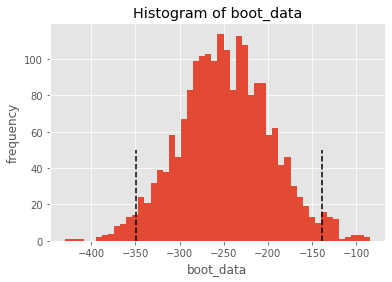

In [79]:
booted_data = get_bootstrap(gorup_a['revenue'], gorup_b['revenue'], boot_it = 2000)

In [89]:
booted_data['ci']

,0
0.025,-349.223099
0.975,-139.163537


In [80]:
booted_data['p_value']

1.50374176782611e-06

In [ ]:
'''При проведении метода Bootstrap был получен уровень значимости 0,00000150374176782611. p-value < 0,0001. 
Это говорит о том, что существуют статистически значимые различия между группами.Доверительный интервал: 
от -349 до -139. Это говорит о том, что 95% наблюдений лежат в данном интервале. 
При этом, средний чек в тестовой группе больше среднего чека в контрольной группе 
(контрольная - 870.672897, тестовая - 1118.836406).
Исходя из полученных данных можно отметить, что новая модель дала лучший результат по сравнению со старой. 
Это говорит о том, что ее можно выкатить на остальных пользователей'''